## TMD implementation


### 1. get a tree;
 - [x] skeleton; max inscribed ball; katere so hitre implementacije?
 - [x] find the two starting points of the trees 
 - [x] follow the skeleton from souce, calc arclen as you go and save all branch points


In [7]:
import numpy as np 
import matplotlib.pyplot as plt
import cc3d
import nrrd
import time
from skimage.morphology import skeletonize, medial_axis, thin, cube, ball, disk, octahedron, binary_dilation
from skimage.segmentation import watershed
from pathlib import Path
from scipy.ndimage import correlate,  distance_transform_edt
from IPython.display import clear_output
from skimage.morphology import convex_hull_image

imgpath = Path("/Users/evabreznik/Desktop/MAIASTUFF/nnUNet_raw/Dataset666_ASOCA/imagesTs")
labelpath = Path("/Users/evabreznik/Desktop/MAIASTUFF/nnUNet_raw/Dataset666_ASOCA/labelsTs/")

#### Image loading

In [13]:
# which img
tip, nr = "D", 18

#load img and label
imname = f"{'Diseased' if tip=='D' else 'Normal'}_{nr}"
#img, headimg = nrrd.read(Path(imgpath, f"{imname}_0000.nrrd" ))
#label, headlab = nrrd.read(Path(labelpath, imname+".nrrd"))
imgg = nib.load(Path("/Users/evabreznik/Desktop/CODING/test_predicted/resampled", f"{imname}_0000.nii.gz"))
labell = nib.load(Path("/Users/evabreznik/Desktop/CODING/test_predicted/resampled", f"{imname}_SM.nii.gz"))
headimg = imgg.header
img = imgg.get_fdata()
headlab = labell.header
label = labell.get_fdata()



#### Handling each main CC separately

In [14]:
# separate to two CCs, analyse each separately. Discard all but smallest two
start = time.time()
labels_out, N = cc3d.connected_components(label, connectivity=26, return_N=True)
#labels_out = cc3d.largest_k(labels_out, k=2, connectivity=26, delta=0)
stats = cc3d.statistics(labels_out)
time_cc3d = time.time()-start #0.3945
print("found", N, "connected components!")

found 2 connected components!


In [15]:

labels_out, N = cc3d.connected_components(label, connectivity=26, return_N=True)
stats = cc3d.statistics(labels_out)
mainCCs = np.argsort(stats['voxel_counts'])[-3:-1]
# Now you have the indices of two main vascular CCs. 
# The first one is smaller in size than the second one, by construction.
# Which is left, which is right:
cc1 = stats['bounding_boxes'][mainCCs[0]]
cc2 = stats['bounding_boxes'][mainCCs[1]]
if cc1[0].start>cc2[0].start:
    L, R = mainCCs[0], mainCCs[1]
  #  Lroot, Rroot = cc1[2].stop, cc2[2].stop
    bbL, bbR = cc1, cc2
else:
    L, R = mainCCs[1], mainCCs[0]
  #  Lroot, Rroot = cc2[2].stop, cc1[2].stop
    bbL, bbR = cc2, cc1

# for faster processing, cut the image to bounding box+1. 
bbL = tuple(slice(max(ind.start-2, 0),  min(ind.stop+3, s), None) for ind, s in zip(bbL, label.shape))
bbR = tuple(slice(max(ind.start-2, 0),  min(ind.stop+3, s), None) for ind, s in zip(bbR, label.shape))

CCdict = {'left': (bbL, stats['voxel_counts'][L], labels_out[*bbL]==L), 'right': (bbR, stats['voxel_counts'][R], labels_out[*bbR]==R)}

# OBS! this root (L/Rroot) is not really well defined, due to possible arches at/near ostia! But for this purpose it should be fine. 

#### Get topological skeleton

In [16]:
#choose one vesseltree
side = 'left'
vessel1 = CCdict[side][-1]

# centerline, thinning, medial axis
#start = time.time()
#skel_medax, distance_out = medial_axis(vessel, return_distance=True) # ONLY FOR 2D!
#Tma = time.time()-start

start = time.time()
skel_base1 = skeletonize(vessel1)
Tbs = time.time()-start

#start = time.time()
#skel_thin = thin(vessel) # ONLY FOR 2D!
#Tth = time.time()-start

side = 'right'
vessel2 = CCdict[side][-1]
skel_base2 = skeletonize(vessel2)

In [4]:
import nibabel as nib
skelL = nib.load("/Users/evabreznik/Desktop/left_skel.nii.gz").get_fdata()
skelR = nib.load("/Users/evabreznik/Desktop/right_skel.nii.gz").get_fdata()

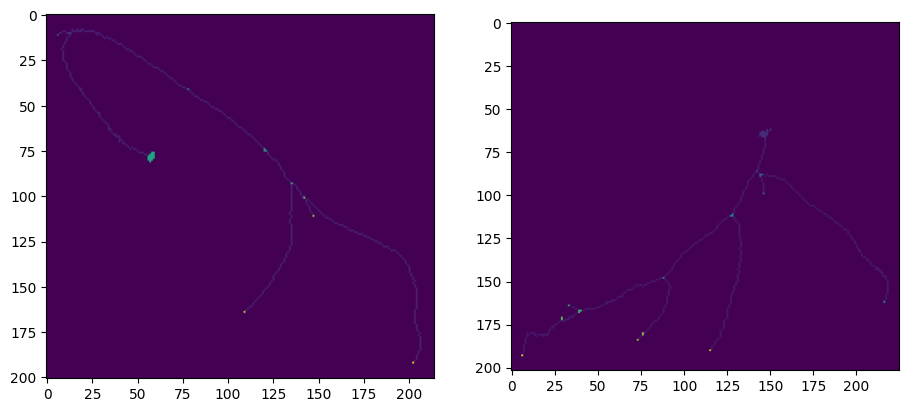

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11, 5))
plt.subplot(1,2,1)
plt.imshow(skelL.max(axis=2))
plt.subplot(1,2,2)
plt.imshow(skelR.max(axis=2))

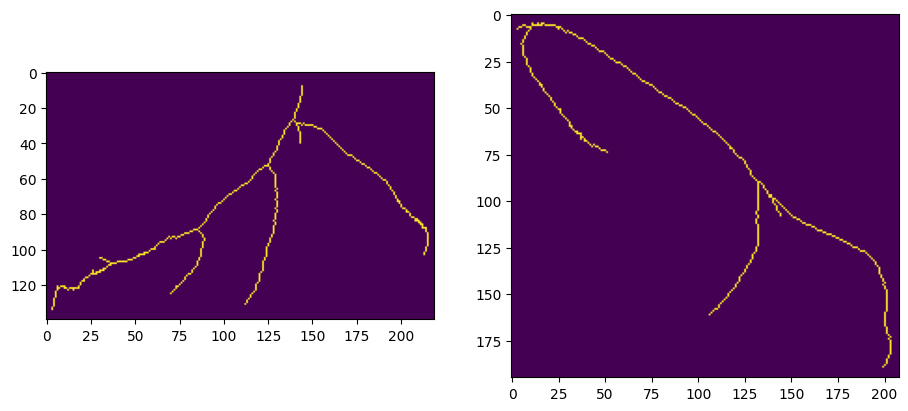

In [17]:
plt.figure(figsize=(11, 5))
plt.subplot(1,2,1)
plt.imshow(skel_base1.max(axis=2))
plt.subplot(1,2,2)
plt.imshow(skel_base2.max(axis=2))
#plt.imshow(img[:,:, 223]) # y: 0=prsi, N=hrbet, x:L-D ali D-L, z: 0=spodaj/noge, N=zgoraj/glava

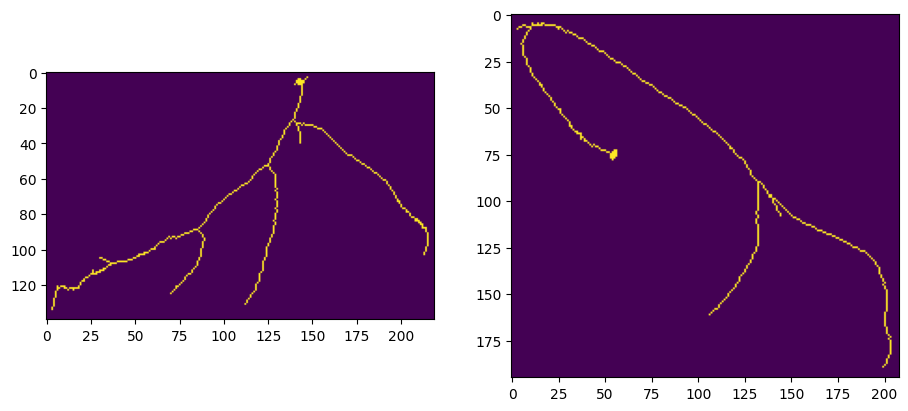

In [31]:
plt.figure(figsize=(11, 5))
plt.subplot(1,2,1)
plt.imshow(skel1.max(axis=2))
plt.subplot(1,2,2)
plt.imshow(skel2.max(axis=2))

#### Find root, leaves and bifurcations

In [32]:
skel_base1_orig = skel_base1.copy()
skel_base2_orig = skel_base2.copy()

More than one candidate for root (L)!


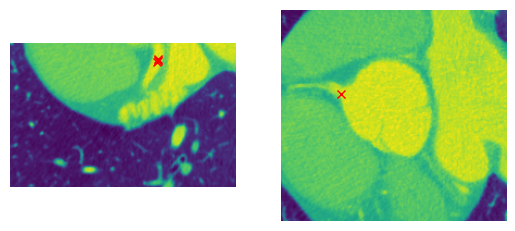

0.029813051223754883


/var/folders/hp/5_jh51mx2s1fvznhhxkhtgzm0000gn/T/ipykernel_5696/3066645885.py:34: FutureWarning: `cube` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  weights = cube(3)


In [33]:
#find actual source in the skeleton: since skeleton is supposedly 1px wide, it suffices to take the top nonzero voxel
skel_base1 = skel1 
skel_base2 = skel2
#LEFT
root1 = skel_base1.shape[2]-1
while not skel_base1[:,:,root1].any():
    root1-=1
viable1 = np.nonzero(skel_base1[:,:,root1])
if len(viable1[0])>1:
    print("More than one candidate for root (L)!")
viable1 = np.stack(viable1)

# RIGHT
root2 = skel_base2.shape[2]-1
while not skel_base2[:,:,root2].any():
    root2-=1
viable2 = np.nonzero(skel_base2[:,:,root2])
if len(viable2[0])>1:
    print("More than one candidate for root (R)!")
viable2 = np.stack(viable2)

#plot underlying imgs and where the roots could be
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img[*bbL][:,:,root1])
plt.plot(viable1[1],viable1[0], 'rx')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img[*bbR][:,:,root2])
plt.plot(viable2[1],viable2[0], 'rx')
plt.axis('off')
plt.show()

weights = cube(3)
#neighbors = correlate(skel_base*1, weights, mode='constant')
leaves1, bifur1 = [], []
leaves2, bifur2 = [], []
start = time.time()
for x,y,z in zip(*np.nonzero(skel_base1)):
    num_ngbhs = skel_base1[x-1:x+2, y-1:y+2, z-1:z+2].sum()
    if num_ngbhs==2:
        leaves1.append((x,y,z))
    elif num_ngbhs>3:
        bifur1.append((x,y,z))
for x,y,z in zip(*np.nonzero(skel_base2)):
    num_ngbhs = skel_base2[x-1:x+2, y-1:y+2, z-1:z+2].sum()
    if num_ngbhs==2:
        leaves2.append((x,y,z))
    elif num_ngbhs>3:
        bifur2.append((x,y,z))
print(time.time()-start) # GANSKA SNABB!

In [20]:
# remove those bifurcation points that neighbor on bifurcation points; keep only the one with highest degree. 
# some things will be done repeatedly but not really a problem here, since we have a low amount of bifurcations;

keeps = []
SE = ball(1)
for bifur, skel_base in zip([bifur1, bifur2],[skel_base1, skel_base2]):
    keep = []
    for i,j,k in bifur:
        possible = [(sh_i, sh_j, sh_k) for sh_i in range(0,3) for sh_j in range(0,3) for sh_k in range(0,3) if (i+sh_i-1, j+sh_j-1, k+sh_k-1) in bifur]
        # now take the weight center and keep that as the only valid bifurcation of this group
        if len(possible)==1:
            keep.append((i,j,k))
        else: #we need to keep only one of them
            tmp = np.zeros((3,3,3))
            tmp[*zip(*possible)] = 1
            tmp2 = correlate(skel_base[i-2:i+3, j-2:j+3, k-2:k+3], SE, mode='constant')[1:-1,1:-1,1:-1]
            
            #now we have a 3x3x3 cube with 1 with neighbor bifur constellation
            #we take the one that has most direct neighbors. (by faces)
            idx = np.argmax(tmp*tmp2) #correlate(tmp, SE, mode='constant'))
            offi, offj, offk = idx//9, idx//3-(idx//9)*3, idx%3
            tokeep = (i+offi-1, j+offj-1, k+offk-1)
            if tokeep not in keep:
                keep.append(tokeep)
            assert tokeep in bifur, [tokeep, bifur]
    keeps.append(keep)

keep1, keep2 = keeps
bifur1 = np.stack(keep1).T
leafs1 = np.stack(leaves1).T
bifur2 = np.stack(keep2).T
leafs2 = np.stack(leaves2).T
# probably all this is not needed; could just take the first one of the possible ones and be done with it. 

In [38]:
len(bifur1[0]), len(bifur2[0]), len(leaves1[0]), len(leaves2[0])

(3, 3, 3, 3)

In [37]:
len(keep1)

7

In [23]:

def get_vessel_neighbors(local_box):
    valid = np.zeros(local_box.shape)
    for mi,mj,mk in zip(*np.nonzero(local_box)):
        if local_box[mi,mj,mk]==1:
            if (local_box[max(mi-1,0):mi+2, max(mj-1,0):mj+2, max(mk-1,0):mk+2]>1).sum()>0: #there's at least one bifur node among the neighbors
                valid[mi,mj,mk] = 1
    return [x for x in zip(*np.nonzero(valid))]
    
bifur_clustering = []
bifur_cluster_coords = []
bifur_cluster_neighbs = []

for bifur, bifur_tuples, skel_base in zip([bifur1, bifur2], [keep1, keep2], [skel_base1, skel_base2]):
    tmp = np.zeros(skel_base.shape)
    tmp[*bifur] = 1
    bf_ccs, N = cc3d.connected_components(tmp, connectivity=26, return_N=True)
    bf_bbs = cc3d.statistics(bf_ccs)
    bf_centers = bf_bbs['centroids']
    bf_bbs = bf_bbs['bounding_boxes']
    for bbid,bb in enumerate(bf_bbs):
        h =[]
        for bbdim in bb:
            h.append(slice(bbdim.start-1, bbdim.stop+1, None))
        bf_bbs[bbid] = tuple(h)
            
    bifur_clustering.append({bf: bf_ccs[*bf] for bf in bifur_tuples})
    bifur_cluster_coords.append([ bf_centers[n] for n in range(1,N+1)]) #just for plotting
    bifur_cluster_neighbs.append([ get_vessel_neighbors(skel_base[bf_bbs[n]]+bf_ccs[bf_bbs[n]]) for n in range(1, N+1)]) # nonbifur neighbrs of a bifur cluster

bifur_cluster_neighbs1, bifur_cluster_neighbs2 = bifur_cluster_neighbs[0], bifur_cluster_neighbs[1]
bifur_cluster_coords1, bifur_cluster_coords2 = bifur_cluster_coords[0], bifur_cluster_coords[1]
bifur_clustering1,  bifur_clustering2 =  bifur_clustering[0],  bifur_clustering[1]

        

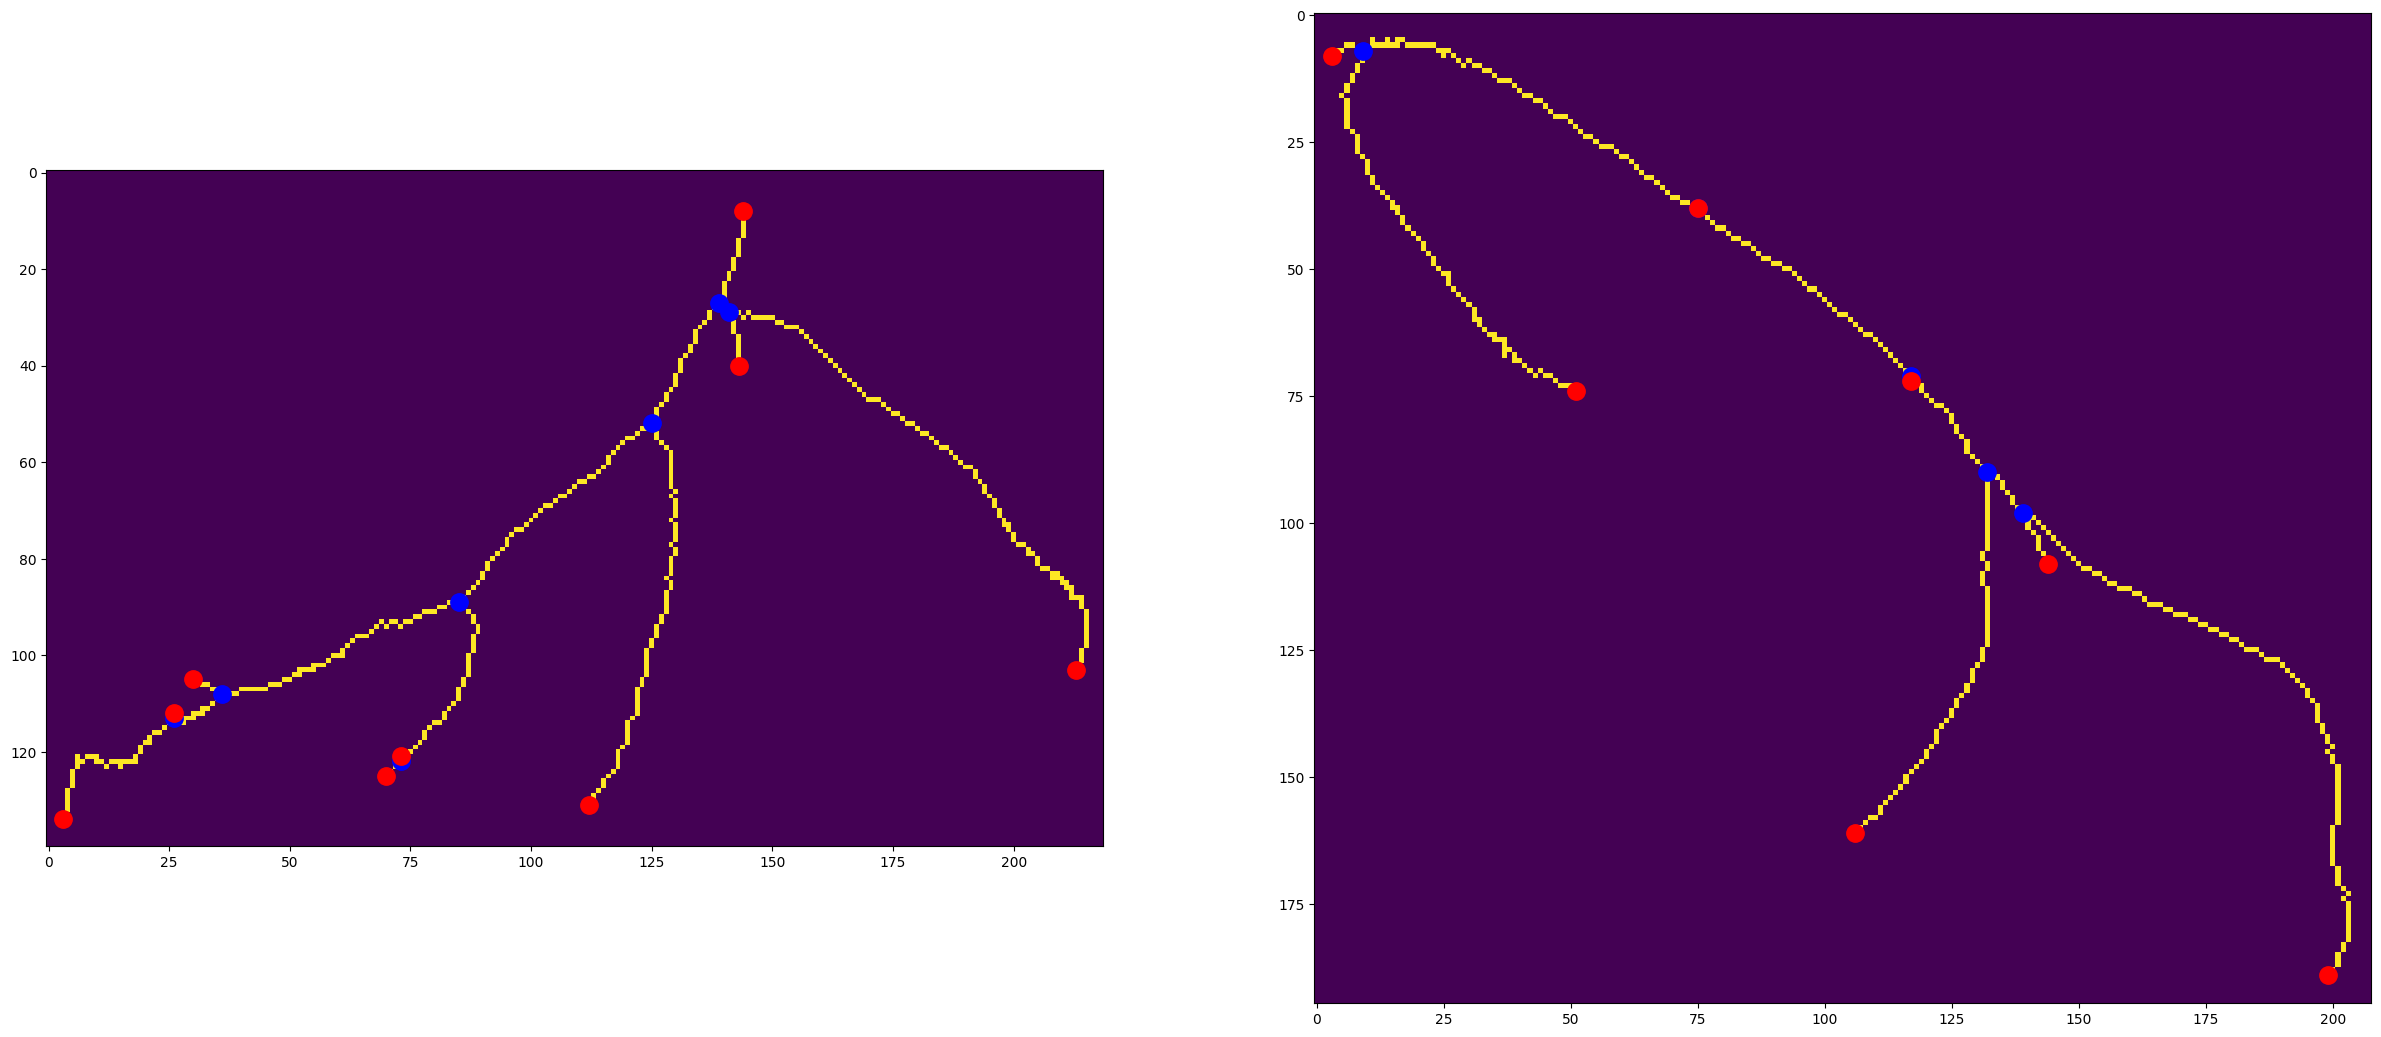

In [24]:
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.imshow(skel_base1.max(axis=2))
tmp = np.stack(bifur_cluster_coords1)
plt.plot(tmp[:,1],tmp[:,0], 'b.', markersize=25)
plt.plot(leafs1[1],leafs1[0], 'r.', markersize=25)
plt.subplot(1,2,2)
plt.imshow(skel_base2.max(axis=2))
tmp = np.stack(bifur_cluster_coords2)
plt.plot(tmp[:,1],tmp[:,0], 'b.', markersize=25)
plt.plot(leafs2[1],leafs2[0], 'r.', markersize=25)

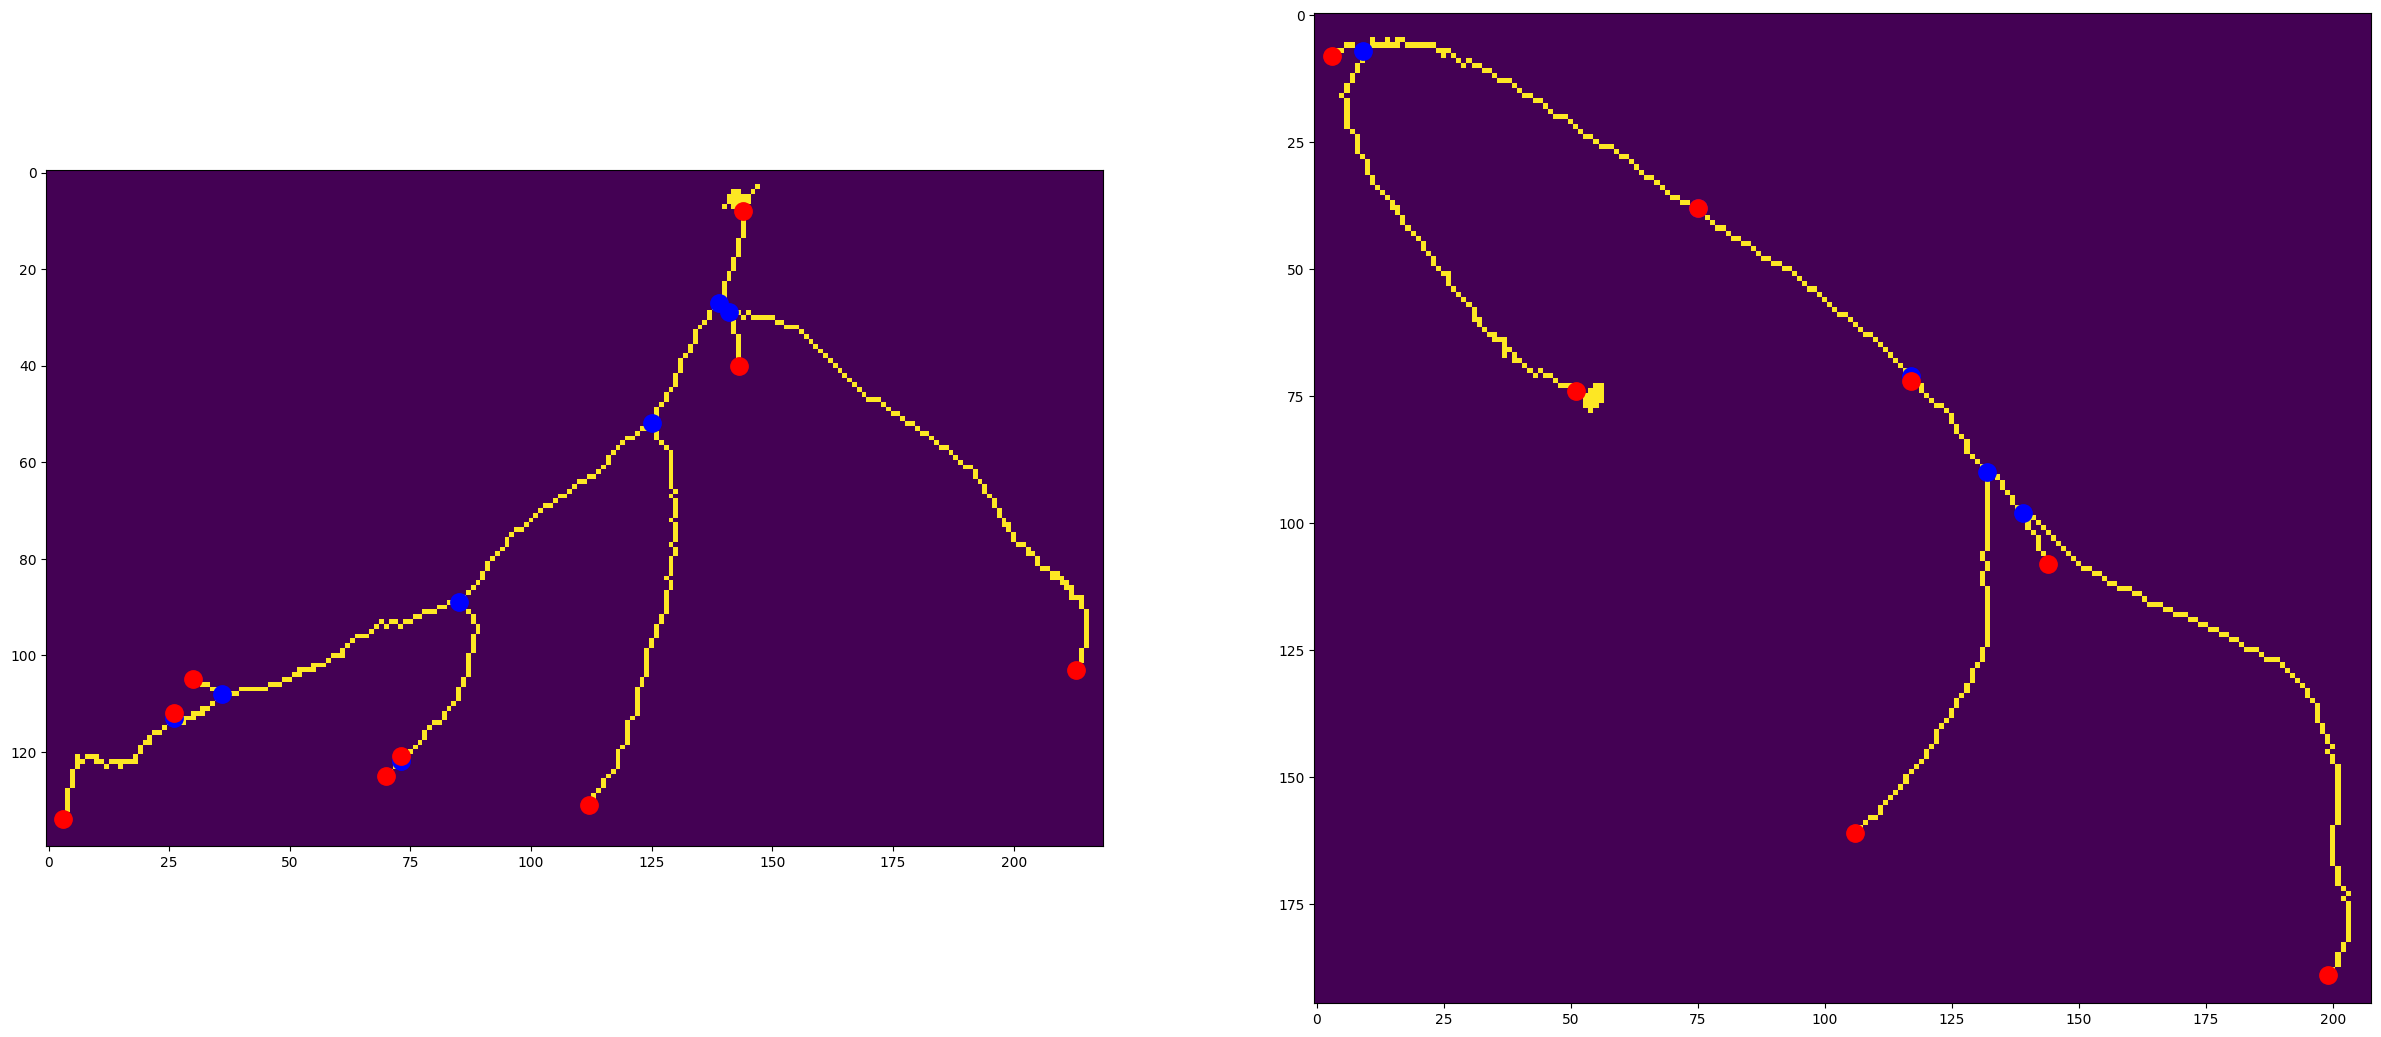

In [41]:
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.imshow(skel_base1.max(axis=2))
tmp = np.stack(bifur_cluster_coords1)
plt.plot(tmp[:,1],tmp[:,0], 'b.', markersize=25)
plt.plot(leafs1[1],leafs1[0], 'r.', markersize=25)
plt.subplot(1,2,2)
plt.imshow(skel_base2.max(axis=2))
tmp = np.stack(bifur_cluster_coords2)
plt.plot(tmp[:,1],tmp[:,0], 'b.', markersize=25)
plt.plot(leafs2[1],leafs2[0], 'r.', markersize=25)

In [42]:
(len(leafs1[0]), len(bifur1[0]), len(leafs2[0]), len(bifur2[0]))

(9, 3, 7, 3)

In [28]:
import scipy.ndimage as ndi
from TMDutils import get_aorta
# now find INFLOW points
#confine aorta to bounding boxes, for inflow finding. 
#now the label will be dilated (within appropriate HU window) until it bumps into aorta. The overlap is
#the inflow point. 
aorta = get_aorta(img, labels_out)
ct_bool1 = img[*bbL]>250
ct_bool2 = img[*bbR]>250

ballsize=1
#aortatmp1 = ndi.binary_dilation(aorta[*bb1], structure=ball(ballsize))&ct_bool1
#aortatmp2 = ndi.binary_dilation(aorta[*bb2], structure=ball(ballsize))&ct_bool2
#inflow1 = np.nonzero(aortatmp1&label1)
labeltmp1 = ndi.binary_dilation(vessel1, structure=ball(ballsize))&ct_bool1
labeltmp2 = ndi.binary_dilation(vessel2, structure=ball(ballsize))&ct_bool2
inflow1 = np.nonzero(labeltmp1&aorta[*bbL])
while len(inflow1[0])==0 and ballsize<5:
    ballsize += 1
    #aortatmp1 = ndi.binary_dilation(aorta[bb1[0], bb1[1], bb1[2]], structure=ball(ballsize))&ct_bool1
    #inflow1 = np.nonzero(aortatmp1&label1)
    labeltmp1 = ndi.binary_dilation(vessel1, structure=ball(ballsize))&ct_bool1
    inflow1 = np.nonzero(labeltmp1&aorta[*bbL])
if ballsize>3:
    print("    OBS ballsize1 ", ballsize)
inflow_centroid1 = np.array([x.mean() for x in inflow1]) #average vsake koordinate

ballsize=1
#inflow2 = np.nonzero(aortatmp2&label2)
inflow2 = np.nonzero(labeltmp2&aorta[*bbR])
while len(inflow2[0])==0 and ballsize<5:
    ballsize += 1
    #aortatmp2 = ndi.binary_dilation(aorta[*bb2], structure=ball(ballsize))&ct_bool2
    #inflow2 = np.nonzero(aortatmp2&label2)
    labeltmp2 = ndi.binary_dilation(vessel2, structure=ball(ballsize))&ct_bool2
    inflow2 = np.nonzero(labeltmp2&aorta[*bbR])
if ballsize>3:
    print("    OBS ballsize2 ", ballsize)
inflow_centroid2 = np.array([x.mean() for x in inflow2]) #average vsake koordinate

#to make sure the skeleton of the vessels will be ok even at the top, and that it will extend all the way to the top (ie to 
#coronary ostia) in the first place, lets add some part of the aorta to the coronary seg that we will skeletonize.
inflow_centroid2_world_coord = inflow_centroid2 + np.array([bbR[0].start, bbR[1].start, bbR[2].start])
inflow_centroid1_world_coord = inflow_centroid1 + np.array([bbL[0].start, bbL[1].start, bbL[2].start])
boxD = np.minimum(inflow_centroid1_world_coord, inflow_centroid2_world_coord).astype(int)
boxU = np.maximum(inflow_centroid1_world_coord, inflow_centroid2_world_coord).astype(int)
aorta_to_keep = np.zeros_like(aorta, dtype=np.uint8)
w = 5
aorta_to_keep[boxD[0]-w:boxU[0]+w, 
                boxD[1]-w:boxU[1]+w, 
                boxD[2]-w:boxU[2]+w] = aorta[boxD[0]-w:boxU[0]+w, 
                                        boxD[1]-w:boxU[1]+w, 
                                        boxD[2]-w:boxU[2]+w]


In [30]:
from skimage.morphology import skeletonize
skel1 = skeletonize(vessel1+aorta_to_keep[*bbL])&vessel1
skel2 = skeletonize(vessel2+aorta_to_keep[*bbR])&vessel2

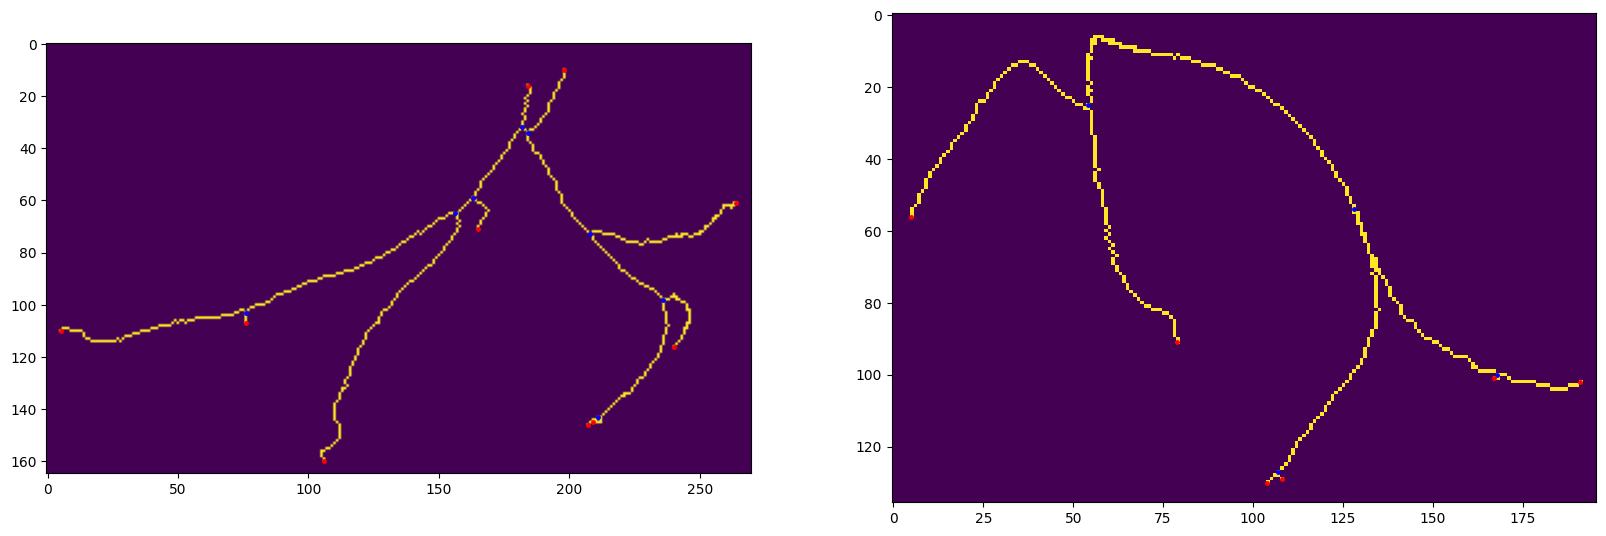

In [21]:
#tako je izgledalo prej, ko so bili lahko sosedi bifurcationi.
plt.figure(figsize=(20,18))
plt.subplot(1,2,1)
plt.imshow(skel_base1.max(axis=2))
plt.plot(bifur1[1],bifur1[0], 'b.', markersize=5)
plt.plot(leafs1[1],leafs1[0], 'r.', markersize=5)
plt.subplot(1,2,2)
plt.imshow(skel_base2.max(axis=2))
plt.plot(bifur2[1],bifur2[0], 'b.', markersize=5)
plt.plot(leafs2[1],leafs2[0], 'r.', markersize=5)

In [23]:
label.shape

(512, 512, 224)

In [26]:
skel_base2.shape

(136, 196, 148)

In [30]:
#saving some stuff to check in 3dslicer
tmp = np.zeros(label.shape, dtype=np.int16)
tmp[*bbL]=skel_base1*1
tmp[*bbR]=skel_base2*2

points = np.zeros(label.shape, dtype=np.int16)
for k in bifur_cluster_coords1: #keep1:
    k = [int(ki) for ki in k]
    points[*bbL][*k] = 1
for l in leaves1:
    points[*bbL][l] = 2
for k in bifur_cluster_coords2: #keep2:
    k = [int(ki) for ki in k]
    points[*bbR][*k] = 3
for l in leaves2:
    points[*bbR][l] = 4
    
nrrd.write(f"centerlines_{tip}{nr}.nrrd", tmp, header=headlab)
nrrd.write(f"centerline_points_{tip}{nr}.nrrd", points, header=headlab)

 ### Create tree from skeleton
 ##### (connect the nodes, define which node is the root, check for cycles?)


In [292]:
class SkeletonTree:
    def __init__(self, data):
        self.structure = dict() #node: [children] #for plotting etc, here nodes are represented by xyz tuples
        self.depth = -1
        self.leaves = []
        self.nodes = []
        self.createFromSkel(data)
    
    def createFromSkel(self, skel):
        pass
        

class Node:
    def __init__(self, xyz, parent=None, fvals={'arclen':0, 'radial':0}):
        self.arclen = fvals['arclen']  # Assign the arclen to this point
        self.radial = fvals['radial']  # Assign the radial distance to this pt
        # ...  # Assign more distances, if needed
        self.parent = None
        self.inflow = None #vector(s) of direction(s) where vessels comes into this point
        self.outflow= None #vector(s) of direction(s) where vessels leave the point
        self.xyz = tuple(xyz) #position in 3D, for better viewing
    def __repr__(self):
        return f"Node{self.xyz}   [dist from root: {self.arclen}]"

    
    

#### Define root and get connectivity graph.

In [32]:
voxelsize = np.diag(headlab['space directions'])
aortalabel = getAortaRef(img)
dist_from_aorta = distance_transform_edt(1-aortalabel, sampling=voxelsize)
komp=np.nonzero(skel_base1)
best_for_root_aorta1 = np.argmin(dist_from_aorta[*bbL][komp])
rootnode1 = list(zip(*komp))[best_for_root_aorta1]
komp=np.nonzero(skel_base2)
best_for_root_aorta2 = np.argmin(dist_from_aorta[*bbR][komp])
rootnode2 = list(zip(*komp))[best_for_root_aorta2]

In [33]:
# add root/source as tree node; should be a leaf node, as close as possible to aorta. Due to thickenings, root may not be detected as leaf! 
# So look among all nonzero pixels instead!

num_leaves1 = len(leafs1[0])
num_leaves2 = len(leafs2[0])
#best_for_root1 = np.argmin([np.sum(np.square(viable1-leafs1[:2,x:x+1]),axis=0).min()+(root1-leafs1[2,x:x+1])**2 for x in range(num_leaves1)])
#rootnode1 = leaves1[best_for_root1]
#best_for_root2 = np.argmin([np.sum(np.square(viable2-leafs2[:2,x:x+1]),axis=0).min()+(root2-leafs2[2,x:x+1])**2 for x in range(num_leaves2)])
#rootnode2 = leaves2[best_for_root2]

nodes_childr1 = {nd: [] for nd in leaves1} | {nd: [] for nd in keep1} | {rootnode1: []}
nodes_dists1 = {nd: 0 for nd in leaves1} | {nd: 0 for nd in keep1} | {rootnode1: 0} #arclen

nodes_childr2 = {nd: [] for nd in leaves2} | {nd: [] for nd in keep2} | {rootnode2: []}
nodes_dists2 = {nd: 0 for nd in leaves2} | {nd: 0 for nd in keep2} | {rootnode1: 0} #arclen

#TODO: rewrite to run this on clusters!

to_visit1 = skel_base1.copy().astype(np.uint8)
stack = [(rootnode1, 0)]
while stack:
    all_children = get_subtree(stack[0][0], stack[0][1], to_visit1, nodes_dists1)
    for ch in all_children:
        nodes_dists1[ch[0]] = ch[1]
        nodes_childr1[stack[0][0]].append(ch[0])
        if ch[0] not in leaves1: #avoid calling on leaves
            stack.append(ch)
    stack = stack[1:]

to_visit2 = skel_base2.copy().astype(np.uint8)
stack = [(rootnode2, 0)]
while stack:
    all_children = get_subtree(stack[0][0], stack[0][1], to_visit2, nodes_dists2)
    for ch in all_children:
        nodes_dists2[ch[0]] = ch[1]
        nodes_childr2[stack[0][0]].append(ch[0])
        if ch[0] not in leaves2: #avoid calling on leaves
            stack.append(ch)
    stack = stack[1:]
    


In [39]:
#check aorta segs and found root nodes: #OBSOLETE
points = aortalabel #np.zeros(label.shape, dtype=np.int16)
points[*bbL][rootnode1] = 2
points[*bbL][rootnode_aorta1] = 3

points[*bbR][rootnode2] = 4
points[*bbR][rootnode_aorta2] = 5

    
nrrd.write(f"centerline_rootnodes_{tip}{nr}.nrrd", points, header=headlab)

#### Visualize (one projection) skeleton with interest points and root(s).

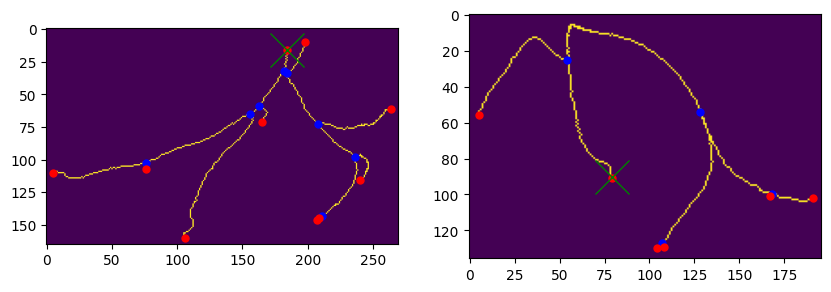

In [35]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.imshow(skel_base1.max(axis=2))
plt.plot(bifur1[1],bifur1[0], 'b.', markersize=10)
plt.plot(leafs1[1],leafs1[0], 'r.', markersize=10)
plt.plot(rootnode1[1], rootnode1[0], 'gx', markersize=25)
#plt.plot(rootnode_aorta1[1], rootnode_aorta1[0], 'k.', markersize=25)
plt.subplot(1,2,2)
plt.imshow(skel_base2.max(axis=2))
plt.plot(bifur2[1],bifur2[0], 'b.', markersize=10)
plt.plot(leafs2[1],leafs2[0], 'r.', markersize=10)
plt.plot(rootnode2[1], rootnode2[0], 'gx', markersize=25)
#plt.plot(rootnode_aorta2[1], rootnode_aorta2[0], 'k.', markersize=25)


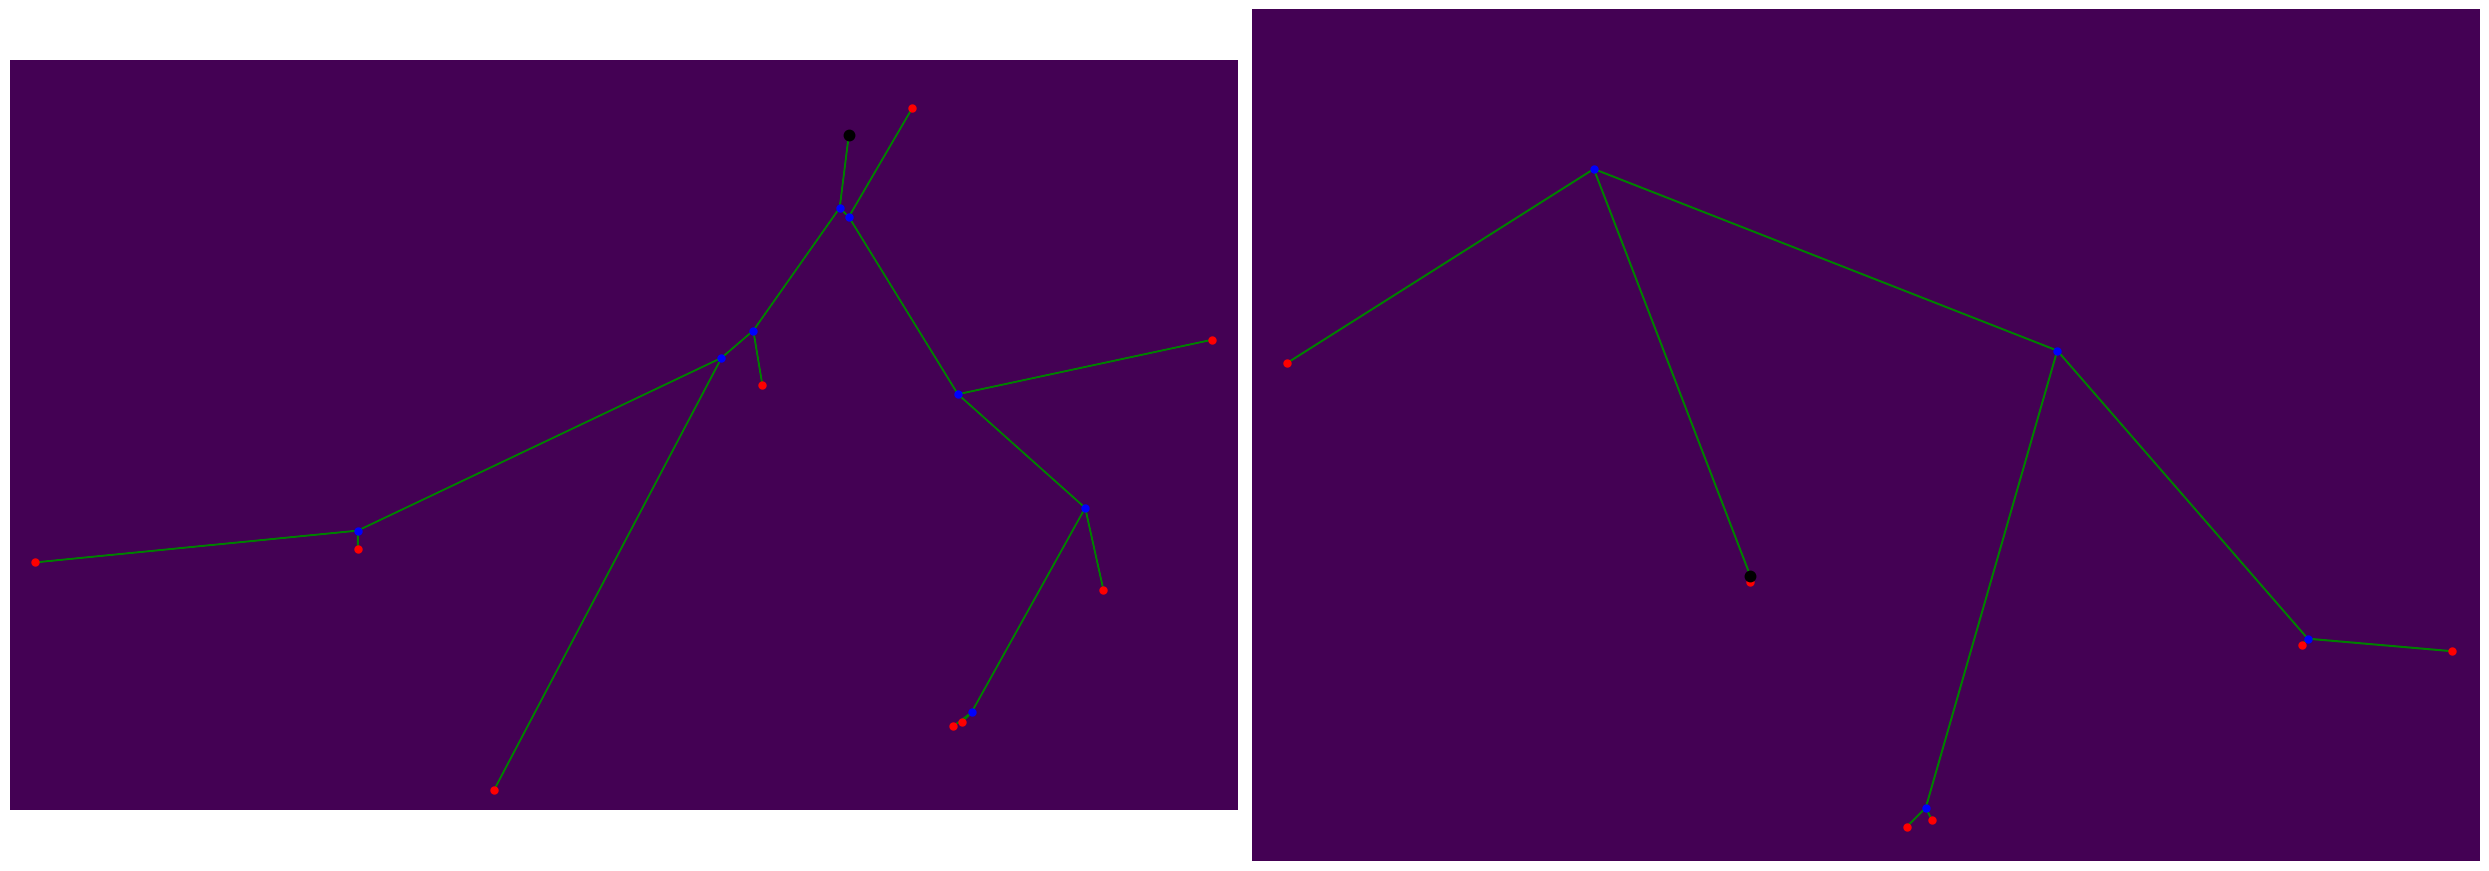

In [41]:
plt.figure(figsize=(25,20))

plt.subplot(1,2,1)
plt.imshow(skel_base1.max(axis=2)*0)
plt.plot(bifur1[1],bifur1[0], 'b.', markersize=10)
plt.plot(leafs1[1],leafs1[0], 'r.', markersize=10)
plt.plot(rootnode1[1],rootnode1[0], 'k.', markersize=15)
for nd in nodes_childr1:
    for fd in nodes_childr1[nd]:
        plt.arrow(nd[1],nd[0], fd[1]-nd[1], fd[0]-nd[0], width=0.1,  ec='green') #head_width=5,
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(skel_base2.max(axis=2)*0)
plt.plot(bifur2[1],bifur2[0], 'b.', markersize=10)
plt.plot(leafs2[1],leafs2[0], 'r.', markersize=10)
plt.plot(rootnode2[1],rootnode2[0], 'k.', markersize=15)
for nd in nodes_childr2:
    for fd in nodes_childr2[nd]:
        plt.arrow(nd[1],nd[0], fd[1]-nd[1], fd[0]-nd[0], width=0.1,  ec='green') #head_width=5,
plt.axis("off")
plt.tight_layout()
plt.savefig("vesselgraph")

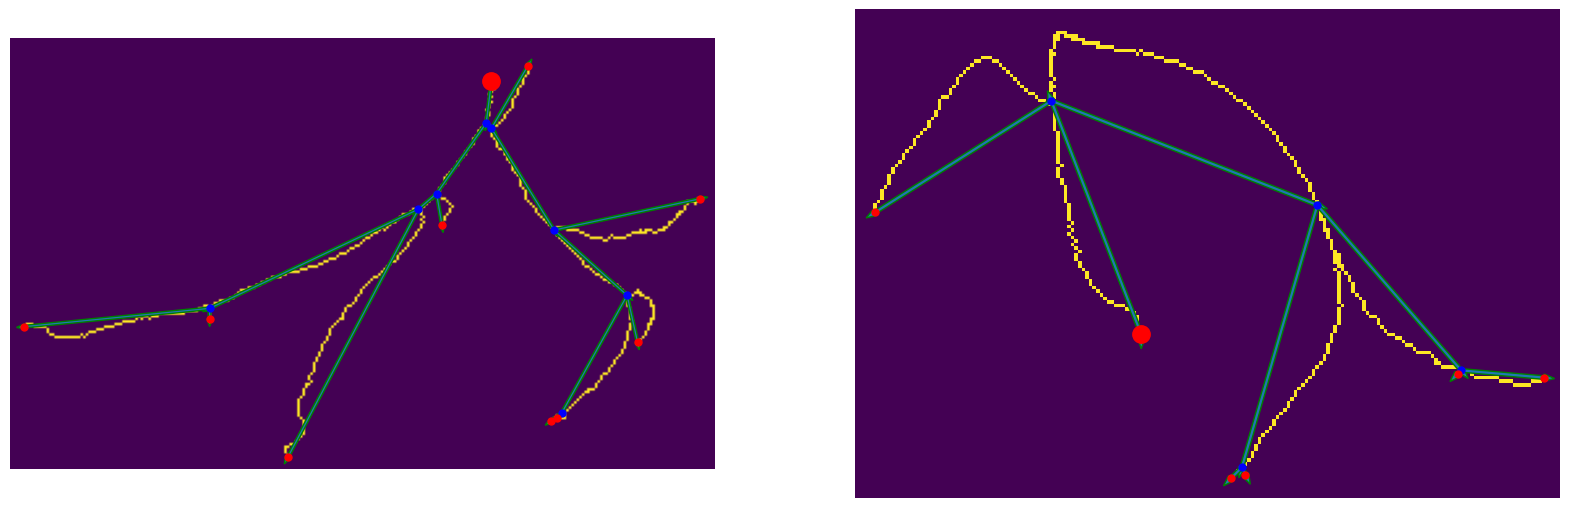

In [42]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(skel_base1.max(axis=2))
plt.plot(bifur1[1],bifur1[0], 'b.', markersize=10)
plt.plot(leafs1[1],leafs1[0], 'r.', markersize=10)
plt.plot(rootnode1[1], rootnode1[0], 'r.', markersize=25)
plt.axis('off')
for nd in nodes_childr1:
    for fd in nodes_childr1[nd]:
        plt.arrow(nd[1],nd[0], fd[1]-nd[1], fd[0]-nd[0], width=1, head_width=2, ec='green') #head_width=5,
plt.subplot(1,2,2)
plt.imshow(skel_base2.max(axis=2))
plt.plot(bifur2[1],bifur2[0], 'b.', markersize=10)
plt.plot(leafs2[1],leafs2[0], 'r.', markersize=10)
plt.plot(rootnode2[1], rootnode2[0], 'r.', markersize=25)
plt.axis('off')
for nd in nodes_childr2:
    for fd in nodes_childr2[nd]:
        plt.arrow(nd[1],nd[0], fd[1]-nd[1], fd[0]-nd[0], width=1, head_width=2, ec='green') #head_width=5,

### 2. run algo:

In [43]:
persist_vec1, assert_root1 = getTMD(nodes_childr1, nodes_dists1)

nrr done: 0
done leaf (10, 198, 95)
done leaf (61, 264, 10)
done leaf (71, 165, 86)
done leaf (107, 76, 58)
done leaf (110, 5, 9)
done leaf (116, 240, 9)
done leaf (145, 209, 3)
done leaf (146, 207, 6)
done leaf (160, 106, 27)
done  (103, 76, 57)
done  (143, 211, 6)
nrr done: 11
done  (65, 156, 86)
done  (98, 236, 46)
nrr done: 13
done  (59, 163, 89)
done  (73, 208, 66)
nrr done: 15
done  (34, 184, 94)
nrr done: 16
done  (32, 182, 96)
nrr done: 17
done  (16, 184, 99)


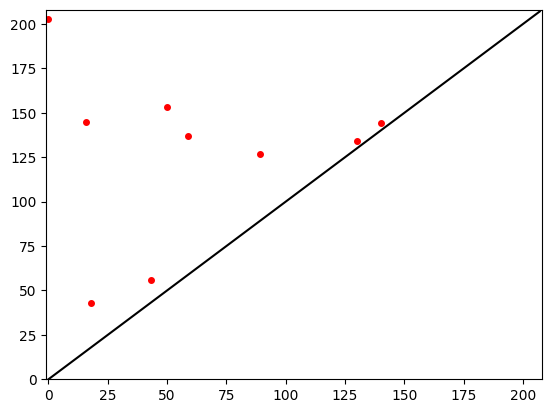

In [46]:
plotPersDiagram(persist_vec1)

### Plot diagrams

In [45]:
def plotBarcode(tuple_list):
    plt.figure()
    for bar in tuple_list:
        plt.line(bar)
    plt.show()

def plotPersDiagram(tuple_list):
    stk = np.stack(tuple_list)
    mm = stk.max()
    plt.figure()
    plt.plot(stk[:,1], stk[:,0], 'r.', markersize=8)
    plt.xlim(-1,mm+5)
    plt.ylim(0,mm+5)
    plt.plot(np.arange(0,mm+5),np.arange(0,mm+5), 'k-')

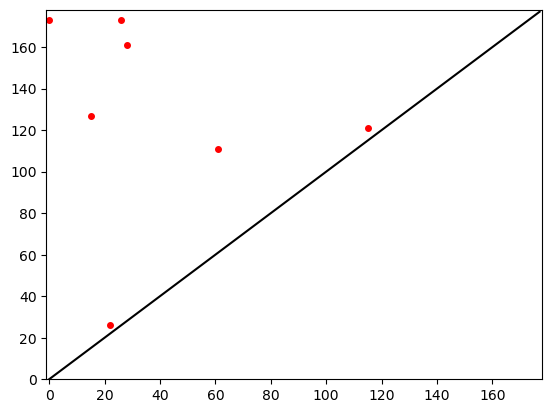

In [483]:
plotPersDiagram(tmd)

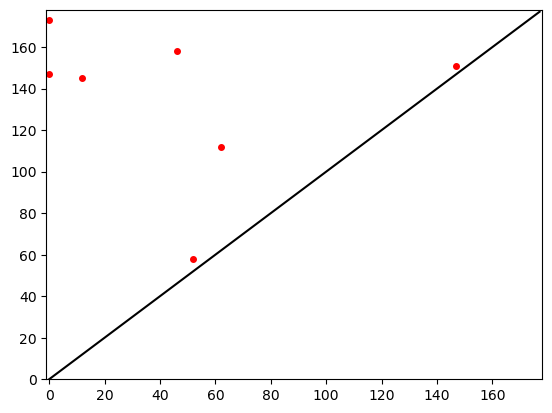

In [488]:
stk = np.stack(tmd)
mm = stk.max()
plt.figure()
plt.plot(mm-stk[:,0], mm-stk[:,1], 'r.', markersize=8)
plt.xlim(-1,mm+5)
plt.ylim(0,mm+5)
plt.plot(np.arange(0,mm+5),np.arange(0,mm+5), 'k-')

NameError: name 'leafs' is not defined

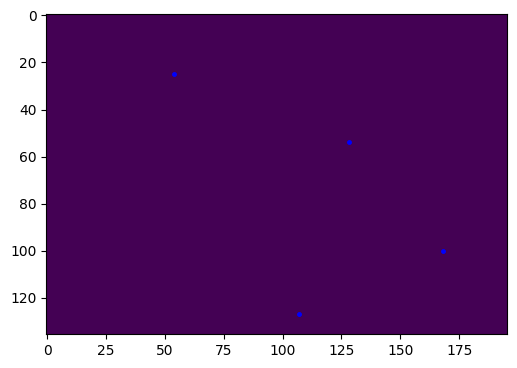

In [ ]:
from matplotlib import gridspec
fig=plt.figure(figsize=(25,5))
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[1, 3], wspace=0.1,
                         hspace=0.01) #, height_ratios=[2, 1])
ax0 = fig.add_subplot(spec[0])
#plt.subplot(2,1,1)
ax0.imshow(skel_base.max(axis=2)*0)

ax0.plot(bifur[1],bifur[0], 'b.', markersize=5)
ax0.plot(leafs[1],leafs[0], 'r.', markersize=5)
for nd in nodes_childr:
    for fd in nodes_childr[nd]:
        ax0.arrow(nd[1],nd[0], fd[1]-nd[1], fd[0]-nd[0], width=0.1,  ec='green') #head_width=5,
ax0.axis("off")

#ax=plt.subplot(2,1,2)
#mm = 173, ie max of all in pers.diag
ax1 = fig.add_subplot(spec[1])
for idx,i in enumerate(tmd):
    ax1.plot([mm-i[0],mm-i[1]],[idx+1,idx+1], 'b-')
    ax1.plot([mm-i[0],mm-i[0]], [0,idx+1], '--', color="0.9")
    ax1.plot([mm-i[1],mm-i[1]], [0,idx+1], '--', color="0.9")
    
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.xticks([0,12, 46, 52, 58, 62,112, 136, 145, 147, 151, 158, 173],[0,12, 46, 52, 58, 62,112, 136, 145, 147, 151, 158, 173]) # [173,161,127,121,115,111,61,37,28,26,22,15,0])
plt.yticks([])
plt.ylim(0,7)

plt.savefig("vesselgraph_barcode")

### 3. Try TMD 
##### Try TMD on all images, both trees. Check to see any pattern/clustering?

In [ ]:
from pathlib import Path
import pickle

pot = Path("/home/maia-user/Desktop/nnUNet_raw/Dataset666_ASOCA/labelsTr")

all_diagrams_arclen = dict()
all_diagrams_radial = dict()
debug = 5
cnt = 0
for imgpot in pot.glob("*.nrrd"):
    cnt+=1
    if cnt==debug:
        break
    #get label img
    label, headlab = nrrd.read(imgpot)
    print(imgpot.name)
    all_diagrams_arclen[imgpot.name] = []
    all_diagrams_radial[imgpot.name] = []
    CCdict = getCCinfo(label)

    #will need approx aorta seg later:
    voxelsize = np.diag(headlab['space directions'])
    aortalabel = getAortaRef(img)
    dist_from_aorta = distance_transform_edt(1-aortalabel, sampling=voxelsize)
    
    #now analyze each branch
    for side in ['left', 'right']:
        print(f"\t side: {side}")
        vessel = CCdict[side][-1]
        bbV = CCdict[side][0]
        #skeletonize and get branch points
        skel_base = skeletonize(vessel)
        splitz, leafz = getBranchPoints(skel_base)
        
        komp = np.nonzero(skel_base)
        best_for_root_aorta = np.argmin(dist_from_aorta[*bbV][komp])
        rootnode = list(zip(*komp))[best_for_root_aorta]

        nodes_childr = {nd: [] for nd in leafz} | {nd: [] for nd in splitz} | {rootnode: []}
        nodes_dists = {nd: 0 for nd in leafz} | {nd: 0 for nd in splitz} | {rootnode: 0} #arclen
        

        #build a graph
        to_visit = skel_base.copy().astype(np.uint8) #perhaps copy is not needed; maybe skel_base is useless form hereon
        stack = [(rootnode, 0)]
        while stack:
            all_children = get_subtree(stack[0][0], stack[0][1], to_visit, nodes_dists)
            for ch in all_children:
                nodes_dists[ch[0]] = ch[1]
                nodes_childr[stack[0][0]].append(ch[0])
                if ch[0] not in leafz: #avoid calling on leaves
                    stack.append(ch)
            stack = stack[1:]
        del stack, to_visit
        #now the stack is empty, tree is ready
        #OPTIONAL: for running with radial distance, compute even that:
        nodes_radial = {nd: sum([(ndi-rooti)**2 for ndi, rooti in zip(nd, rootnode)]) for nd in nodes_dists} 
        
        # run TMD!
        print("\t running TMD...")
        persist_vec, assert_root = getTMD(nodes_childr, nodes_dists)
        assert assert_root==rootnode, (assert_root, rootnode)
        persist_vec_rad, assert_root_rad = getTMD(nodes_childr, nodes_radial)
        assert assert_root_rad==rootnode, (assert_root_rad, rootnode)

        #TODO: various ways to calc distance between persistence vectors of this kind/pers.diagrams. 
        #TODO: save persistence diags for each image (both sides) to some reasonable format
        #TODO: cluster per.diags, to see if you can detect coronary dominance 
        all_diagrams_arclen[imgpot.name].append(persist_vec)
        all_diagrams_radial[imgpot.name].append(persist_vec_rad)
            
#save the dicts 
with open('pers_vecs_arclen.pkl', 'wb') as fp:
    pickle.dump(all_diagrams_arclen, fp)
with open('pers_vecs_radial.pkl', 'wb') as fp:
    pickle.dump(all_diagrams_radial, fp)            
                

Diseased_4.nrrd
	 side: left
	 running TMD...
	 side: right
	 running TMD...
Diseased_17.nrrd
	 side: left
	 running TMD...
	 side: right
	 running TMD...
Normal_11.nrrd
	 side: left
	 running TMD...
	 side: right
	 running TMD...


In [544]:
#now cluster/check differences based on heatlhy/diseased, or general clustering of l-r pairs to two classes;
#maybe it finds different dominance. Otherwise, can ti discern between left and right?

In [ ]:
#TODO: order by length or start?
plt.figure()
distance = all_diagrams_radial
mm=256
N=len(distance)
n=0
for subj in distance:
    n+=1
    diagrama = distance[subj]
    #normalize lengths such that the longest component is always 256 long. 
    maxi = max([di[0] for di in diagrama[0]]+[di[1] for di in diagrama[0]]+[di[0] for di in diagrama[1]]+[di[1] for di in diagrama[1]])
    #plot both left and right on same graph. 
    plt.subplot(1,N,n)
    for idx,i in enumerate(diagrama[0]):
        plt.plot([mm-i[0]*(mm/maxi),mm-i[1]*(mm/maxi)],[idx+1,idx+1], 'b-')
        plt.plot([mm-i[0]*(mm/maxi),mm-i[0]*(mm/maxi)], [0,idx+1], '--', color="0.9")
        plt.plot([mm-i[1]*(mm/maxi),mm-i[1]*(mm/maxi)], [0,idx+1], '--', color="0.9")
    offset=idx+1
    for idx2,i in enumerate(diagrama[1]):
        idx = idx2+offset
        plt.plot([mm-i[0]*(mm/maxi),mm-i[1]*(mm/maxi)],[idx+1,idx+1], 'r-')
        plt.plot([mm-i[0]*(mm/maxi),mm-i[0]*(mm/maxi)], [0,idx+1], '--', color="0.9")
        plt.plot([mm-i[1]*(mm/maxi),mm-i[1]*(mm/maxi)], [0,idx+1], '--', color="0.9")
        

In [ ]:
def getCCinfo(label):
    labels_out, N = cc3d.connected_components(label, connectivity=26, return_N=True)
    stats = cc3d.statistics(labels_out)
    mainCCs = np.argsort(stats['voxel_counts'])[-3:-1]
    # Now you have the indices of two main vascular CCs. 
    # The first one is smaller in size than the second one, by construction.
    # Which is left, which is right:
    cc1 = stats['bounding_boxes'][mainCCs[0]]
    cc2 = stats['bounding_boxes'][mainCCs[1]]
    if cc1[0].start>cc2[0].start:
        L, R = mainCCs[0], mainCCs[1]
      #  Lroot, Rroot = cc1[2].stop, cc2[2].stop
        bbL, bbR = cc1, cc2
    else:
        L, R = mainCCs[1], mainCCs[0]
      #  Lroot, Rroot = cc2[2].stop, cc1[2].stop
        bbL, bbR = cc2, cc1
    
    # for faster processing, cut the image to bounding box+1. 
    bbL = tuple(slice(max(ind.start-1, 0),  min(ind.stop+1, s), None) for ind, s in zip(bbL, label.shape))
    bbR = tuple(slice(max(ind.start-1, 0),  min(ind.stop+1, s), None) for ind, s in zip(bbR, label.shape))
    
    CCdict = {'left': (bbL, stats['voxel_counts'][L], labels_out[*bbL]==L), 'right': (bbR, stats['voxel_counts'][R], labels_out[*bbR]==R)}
    return CCdict

def getAortaRef(img):
    #find start of aorta
    aorta_start = cc3d.connected_components(img[...,-1]>500, connectivity=26)
    sta = cc3d.statistics(aorta_start)["bounding_boxes"]
    from_center = [np.square([(bb[0].start+bb[0].stop)/2-img.shape[0]/2, (bb[1].start+bb[1].stop)/2-img.shape[1]/2]).sum() for bb in sta[1:]]
    closest_to_center = np.argmin(from_center)+1
    aorta = aorta_start==closest_to_center

    #flood down for approx.seg:
    aorta_refr = sta[closest_to_center] #binary_dilation(aorta, footprint=disk(2))
    xstart = aorta_refr[0].start-25
    xstop = aorta_refr[0].stop+25
    ystart = aorta_refr[1].start-25
    ystop = aorta_refr[1].stop+25
    xl, yl = (aorta_refr[0].stop-aorta_refr[0].start)//2, (aorta_refr[1].stop-aorta_refr[1].start)//2
    aortalab = cc3d.connected_components(img[xstart:xstop, ystart:ystop, :]>500, connectivity=26)
    aortalab = aortalab==aortalab[xl, yl, -1] #take only the right CC        
    aortalabel = np.zeros(img.shape, dtype=np.int16)
    aortalabel[xstart:xstop, ystart:ystop, :] = aortalab
    for sls in range(aortalab.shape[-1]-2, 0, -1):
        if aortalabel[...,sls].sum()==0:
            break
        aortalabel[...,sls] = binary_dilation(convex_hull_image(aortalabel[...,sls]), footprint=disk(2))
    
    return aortalabel


#for sls in [-1, -10, -15, -25,-30, -35, -40, -45,-50, -55,-60, -65]:
#    clear_output(wait=True)
#    #plt.imshow(img[...,sls]-1000*aortalabel[...,sls])
#    plt.imshow(aortalabel[...,sls])
#    plt.show()
#    time.sleep(1)


def getBranchPoints(skel_base):
    #get root 
    #root = skel_base.shape[2]-1
    #while not skel_base[:,:,root].any():
    #    root-=1
    #viable = np.nonzero(skel_base[:,:,root])
  #  if len(viable[0])>1:
  #      print("More than one candidate for root!")
    #viable = np.stack(viable)

    #weights = cube(3)
    #neighbors = correlate(skel_base*1, weights, mode='constant')
    leaves, bifur = [], []
    for x,y,z in zip(*np.nonzero(skel_base)):
        num_ngbhs = skel_base[x-1:x+2, y-1:y+2, z-1:z+2].sum()
        if num_ngbhs==2:
            leaves.append((x,y,z))
        elif num_ngbhs>3:
            bifur.append((x,y,z))
    
    # remove those bifurcation points that neighbor on bifurcation points; keep only the one with highest degree. 
    # some things will be done repeatedly but not really a problem here, since we have a low amount of bifurcations;
    keep = []
    SE = ball(1)
    for i,j,k in bifur:
        possible = [(sh_i, sh_j, sh_k) for sh_i in range(0,3) for sh_j in range(0,3) for sh_k in range(0,3) if (i+sh_i-1, j+sh_j-1, k+sh_k-1) in bifur]
        # now take the weight center and keep that as the only valid bifurcation of this group
        if len(possible)==1:
            keep.append((i,j,k))
        else: #we need to keep only one of them
            tmp = np.zeros((3,3,3))
            tmp[*zip(*possible)] = 1
            #now we have a 3x3x3 cube with 1 with neighbor bifur constellation
            #we take the one that has most direct neighbors. (by faces)
            idx = np.argmax(tmp*correlate(tmp, SE, mode='constant'))
            offi, offj, offk = idx//9, idx//3-(idx//9)*3, idx%3
            tokeep = (i+offi-1, j+offj-1, k+offk-1)
            if tokeep not in keep:
                keep.append(tokeep)
            assert tokeep in bifur, [tokeep, bifur]

    #find also best candidate for root
    leafs = np.stack(leaves).T
    num_leaves = len(leaves)
  #  best_for_root = np.argmin([np.sum(np.square(viable-leafs[:2,x:x+1]),axis=0).min()+(root-leafs[2,x:x+1])**2 for x in range(num_leaves)])

    return keep, leaves #, best_for_root

#bifur = np.stack(keep).T
#leafs = np.stack(leaves).T


#get connections between a node and its children. calculate arclen as you go
def get_subtree(node, distance, to_visit, nodelist):
    roi = to_visit[node[0]-1:node[0]+2, node[1]-1:node[1]+2, node[2]-1:node[2]+2]
    roi[1,1,1] = 0 
    directions = list(zip(*np.nonzero(roi)))
    to_visit[node[0]-1:node[0]+2, node[1]-1:node[1]+2, node[2]-1:node[2]+2] = 0 #all directions are set to 0
    
    children = []
    for dirx in directions:        
        current_node = tuple(i+j-1 for i,j in zip(dirx, node)) #node we're at at the moment
        dist = distance+1
        
        while current_node not in nodelist: #not bifur, nor leaf
            subroi = to_visit[current_node[0]-1:current_node[0]+2, current_node[1]-1:current_node[1]+2, current_node[2]-1:current_node[2]+2]
            subroi[1,1,1] = 0 #cant stay on the same pixel
            #all possible directions from here:
            dirs = list(tuple(i+j-1 for i,j in zip(current_node, one_dir)) for one_dir in zip(*np.nonzero(subroi)))
            if len(dirs)==0:
                break #got to a leaf. bit weird it's not in the list but oh well. Shouldnt really happen.
            to_visit[*current_node] = 0 #the current_node has been visited, and is not bifur/leaf, so tick it off. 
            current_node = dirs[0] #choose next node to move to
            #but go first to the bifurcation, if one among the neighbors is bifur.
            for d in dirs:
                if d in nodelist:
                    current_node = d
                    break
            dist += 1
                  
        children.append((current_node, dist))
    return children
#TIP if reimplementing: actually going from leaves up would probably help you avoid many issues. 


#easier impl of TMD, based on the data structures I use in tree building:
def getTMD(nodes_childr, func):
    persist = []
    rootnode = (None,None,None)
    v = dict() #stores v values, but also keeps track of what's been "done"
    nr_done = 0
    Nn = len(nodes_childr)
    
    while nr_done!=Nn:
        print("nrr done:", nr_done)
        for node, node_chs in nodes_childr.items():
            if node in v: 
                #already been done; and all its children have been processed
                continue
            rootnode = node #the last node we visit altogether should be the root. 
            if len(node_chs)==0:
                #leaf node
                v[node] = func[node]
                nr_done+=1
                print("done leaf", node)
            elif np.all([c in v for c in node_chs]): #all children already have assigned v. This is True even when at leaf nodes. 
                nr_done+=1 #node is being done now too. (Done = assigned v value.) 
                print("done ", node)
                tmp = [v[c] for c in node_chs]
                best = np.argmax(tmp)
                v[node] = tmp[best]
                for i in range(len(tmp)):
                    if i!=best:
                        persist.append((tmp[i], func[node]))
    #add also root/main comp                    
    persist.append((v[rootnode], func[rootnode]))
  #  print("got to rootnode", rootnode)
  #  print(v)
    return persist, rootnode